In [ ]:
!pip install pandas gpxpy contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 50.8 MB/s eta 0:00:00


In [ ]:
import gdown

import pandas as pd
import seaborn as sns

import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import contextily as ctx

In [ ]:
WAYPOINTS_GPX = 'waypoints.gpx'

YEAR = 2024
WAYPOINTS_GPX_URL = 'https://drive.google.com/file/d/1KK8d8D3UgI47qxCalTdB0jyYWgMsqhaC/view?usp=sharing'

gdown.download(WAYPOINTS_GPX_URL, WAYPOINTS_GPX, quiet=True, fuzzy=True)

'waypoints.gpx'

In [80]:
def fix_timestamps(val):
    parts = val.split()
    parts[1] = parts[1][:-1]
    return ' '.join(parts)

def parse_waypoints(filepath):
  tree = ET.parse(filepath)
  root = tree.getroot()

  ns = {'default': 'http://www.topografix.com/GPX/1/1'}
  waypoints = [
      (
          wpt.find('default:name', ns).text,
          float(wpt.attrib['lat']),
          float(wpt.attrib['lon']),

      ) for wpt in root.findall('default:wpt', ns)
  ]
  df = pd.DataFrame(waypoints, columns=[
      'name',
      'lat',
      'lon',
  ])

  df['name'] = df['name'].apply(fix_timestamps)
  df['name'] = df['name'].apply(lambda x: f'{x} {YEAR}')
  df['time'] = pd.to_datetime(df['name'], format='%d-%b %H%M %Y')

  df = df.drop('name', axis=1)

  return df

df = parse_waypoints(WAYPOINTS_GPX)

df.head(3)

,lat,lon,time
0,21.011083,105.859525,2024-09-01 07:01:00
1,21.003482,105.861731,2024-09-01 07:02:00
2,21.000790,105.861993,2024-09-01 07:02:00


In [81]:
daily_counts = df['time'].dt.date.value_counts().sort_index()
daily_counts

,count
time,
2024-08-11,77
2024-08-17,11
2024-08-18,5
2024-08-24,6
2024-08-25,7
2024-09-01,5
2024-09-15,10
2024-09-21,4


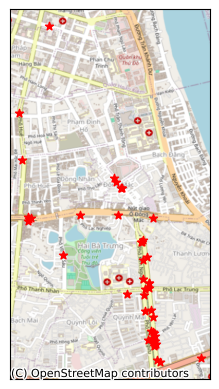

In [ ]:
def plot(df):
    plt.figure()
    plt.scatter(df['lon'], df['lat'], color='red', marker='*')
    plt.gca().set_aspect('equal', adjustable='box')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()

start_date = pd.Timestamp('2024-08-17')
filtered_df = df[df['time'] >= start_date]

plot(filtered_df)

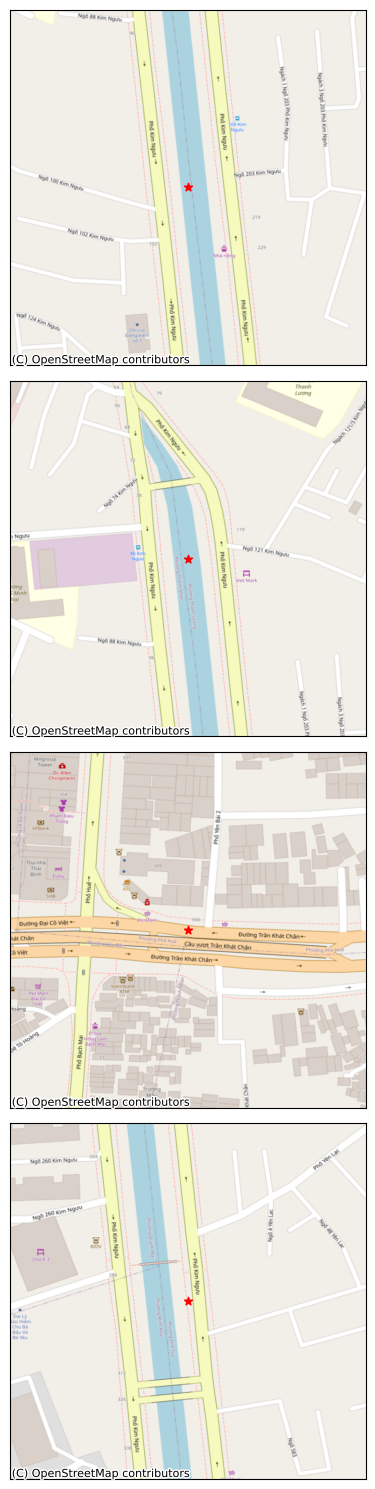

In [ ]:
def plot_waypoints(df):
    fig, axes = plt.subplots(nrows=len(df), ncols=1, figsize=(10, 15))

    df.reset_index(drop=True, inplace=True)
    for idx, row in df.iterrows():
        ax = axes[idx]

        lon, lat = row['lon'], row['lat']
        ax.scatter(lon, lat, color='red', marker='*')

        zoom_level = 0.001  # Smaller values zoom in more
        ax.set_xlim(lon - zoom_level, lon + zoom_level)
        ax.set_ylim(lat - zoom_level, lat + zoom_level)

        ax.set_aspect('equal', adjustable='box')
        ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)

    plt.tight_layout()
    plt.show()

start_date = pd.Timestamp('2024-09-21')
filtered_df = df[df['time'] >= start_date]

plot_waypoints(filtered_df)

<ipython-input-82-014e833a5b3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['time'].dt.hour
<ipython-input-82-014e833a5b3d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['minute'] = df['time'].dt.minute


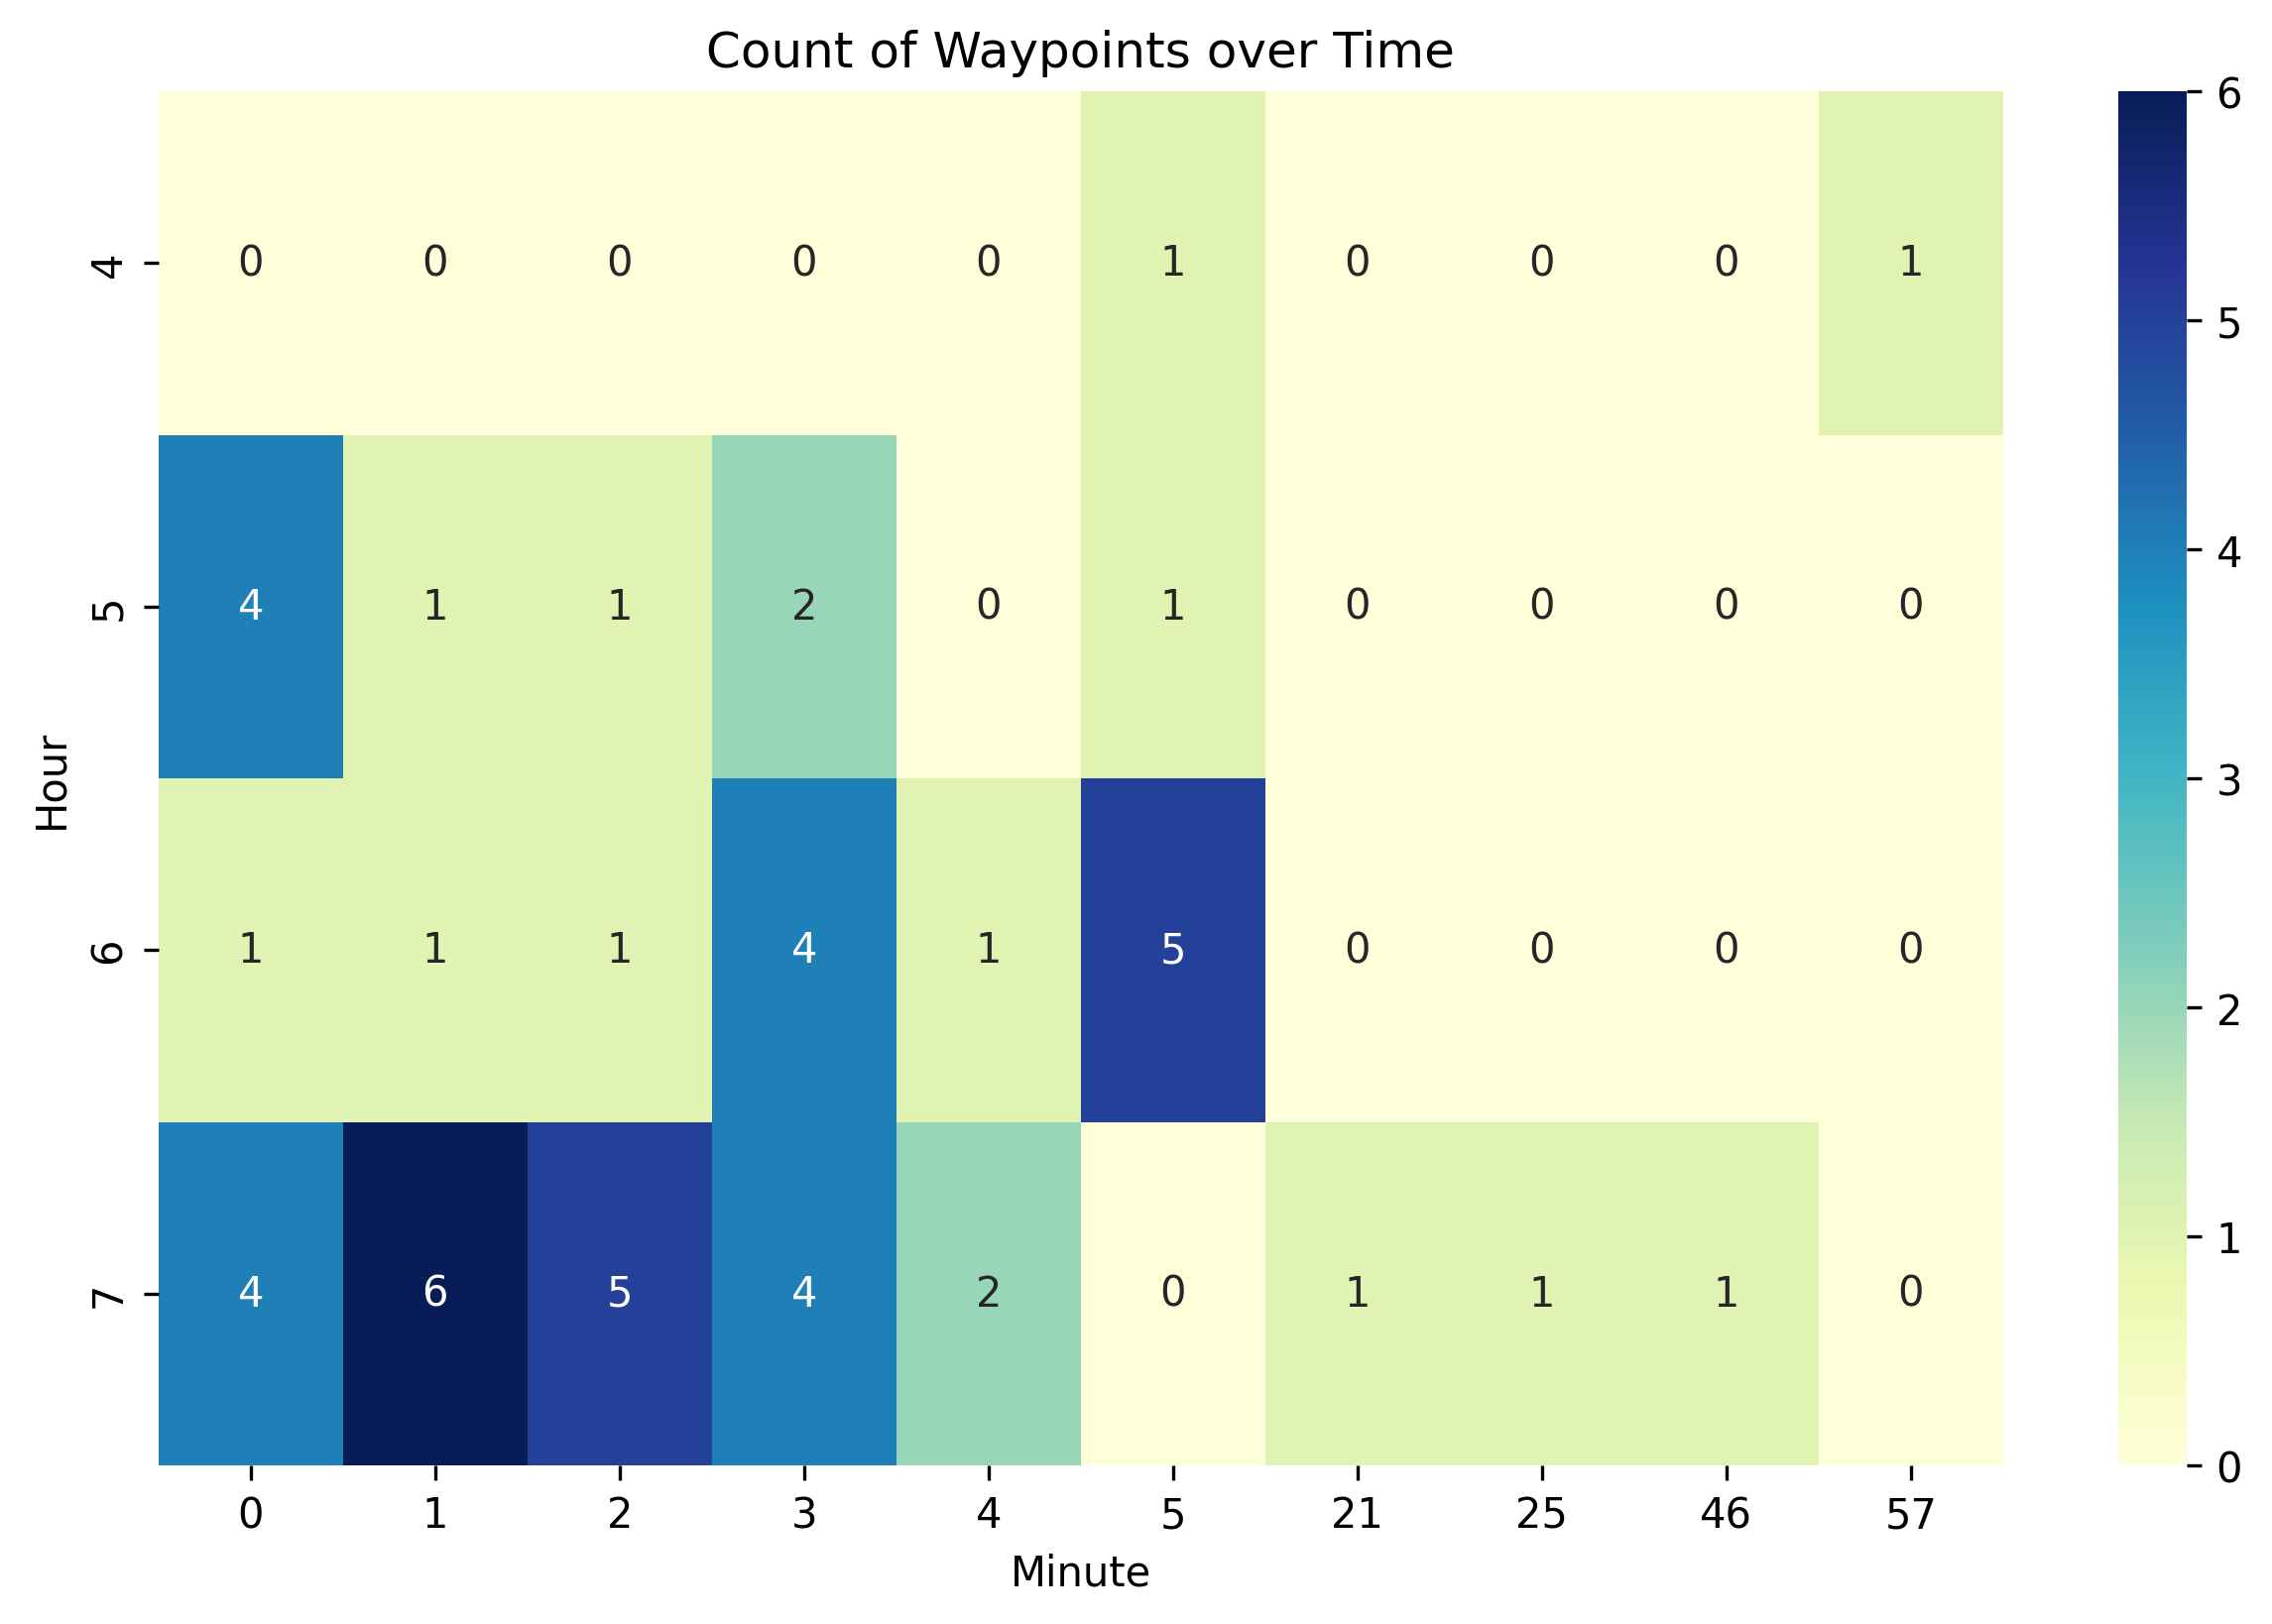

In [82]:
def plot_heatmap(df):
  df['hour'] = df['time'].dt.hour
  df['minute'] = df['time'].dt.minute

  grouped = df.groupby(['hour', 'minute']).size().reset_index(name='count')
  pivot = grouped.pivot(index='hour', columns='minute', values='count').fillna(0)

  plt.figure(figsize=(10, 6), dpi=300)
  sns.heatmap(pivot, cmap='YlGnBu', annot=True)
  plt.title('Count of Waypoints over Time')
  plt.xlabel('Minute')
  plt.ylabel('Hour')
  plt.show()

start_date = pd.Timestamp('2024-08-17')
filtered_df = df[df['time'] >= start_date]

plot_heatmap(filtered_df)